Downloading the data

In [1]:
#  Phase 1: IMDB Review Data Prep
import os
import tarfile
import urllib.request
import shutil

#Define source link and archive label
data_link_v = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
archive_name_v = "reviews_raw_archive.tar.gz"

#Fetch the archive if missing
urllib.request.urlretrieve(data_link_v, archive_name_v)

#Unzip the downloaded archive
if archive_name_v.endswith("tar.gz"):
    with tarfile.open(archive_name_v, "r:gz") as unpack:
        unpack.extractall()

#Delete unwanted data directory (unlabeled samples)
trash_path_v = os.path.join("aclImdb", "train", "unsup")
if os.path.isdir(trash_path_v):
    shutil.rmtree(trash_path_v)

print("Review data downloaded, unpacked, and cleaned up!")

/tmp/ipython-input-1343571182.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  unpack.extractall()


Review data downloaded, unpacked, and cleaned up!


In [ ]:
#!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar -xf aclImdb_v1.tar.gz
#!rm -r aclImdb/train/unsup

Preparing the data

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras

#Define batch size and directory paths
chunk_size_v = 32
root_path_v = pathlib.Path("aclImdb")
validation_path_v = root_path_v / "val"
training_path_v = root_path_v / "train"

#Create validation directories and redistribute 20% data from train
for label in ("neg", "pos"):
    os.makedirs(validation_path_v / label, exist_ok=True)
    content_files_v = os.listdir(training_path_v / label)
    random.Random(1337).shuffle(content_files_v)
    split_count_v = int(0.2 * len(content_files_v))
    move_to_val_v = content_files_v[-split_count_v:]
    for document in move_to_val_v:
        shutil.move(training_path_v / label / document,
                    validation_path_v / label / document)

#Build TensorFlow datasets from the folders
review_train_v = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size_v=chunk_size_v
)
review_valid_v = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size_v=chunk_size_v
)
review_test_v = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size_v=chunk_size_v
)

#Text-only version of training set
train_text_stream_v = review_train_v.map(lambda text, label: text)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Base Model

Preparing integer sequence datasets

In [ ]:
from tensorflow.keras import layers

#Define vectorization settings
seq_limit_v = 600
vocab_limit_v = 20000

token_encoder_v = layers.TextVectorization(
    max_tokens_v=vocab_limit_v,
    output_mode_v="int",
    output_sequence_length_v=seq_limit_v,
)

#Fit the vectorizer on raw training text
token_encoder_v.adapt(train_text_stream_v)

#Transform datasets to integer sequences
train_encoded_v = review_train_v.map(
    lambda text, label: (token_encoder_v(text), label),
    num_parallel_calls_v=4)

val_encoded_v = review_valid_v.map(
    lambda text, label: (token_encoder_v(text), label),
    num_parallel_calls_v=4)

test_encoded_v = review_test_v.map(
    lambda text, label: (token_encoder_v(text), label),
    num_parallel_calls_v=4)

A sequence model built on one-hot encoded vector sequences

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

#Vocabulary cap
vocab_size_v = 20000

#Model architecture
entry_v = tf.keras.Input(shape=(None,), dtype="int64")

#Word embeddings
word_embed_v = layers.Embedding(input_dim_v=vocab_size_v, output_dim_v=128)(entry_v)

#Bidirectional LSTM layer
sequence_flow_v = layers.Bidirectional(layers.LSTM(32))(word_embed_v)

#Regularization
sequence_flow_v = layers.Dropout(0.5)(sequence_flow_v)

#Output unit
prediction_v = layers.Dense(1, activation="sigmoid")(sequence_flow_v)

#Build and compile model
sentiment_net_v = tf.keras.Model(entry_v, prediction_v)
sentiment_net_v.compile(optimizer="rmsprop",
                      loss_v="binary_crossentropy",
                      metrics_v=["accuracy"])
sentiment_net_v.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,281 (9.92 MB)

 Trainable params: 2,601,281 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Training a first basic sequence model

In [ ]:
#Save best model using checkpoint
monitoring_tools_v = [
    keras.callbacks_v.ModelCheckpoint("lstm_best_model.keras", save_best_only=True)
]

#Train the model
training_trace_v = sentiment_net_v.fit(
    train_encoded_v,
    validation_data_v=val_encoded_v,
    epochs_v=10,
    callbacks_v=monitoring_tools_v
)

#Reload the best-performing version
best_model_v = keras.models.load_model("lstm_best_model.keras")

#Final evaluation on test set
final_accuracy_v = best_model_v.evaluate(test_encoded_v)[1]
print(f"Final Test Accuracy: {final_accuracy_v:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.6356 - loss: 0.6205 - val_accuracy: 0.7774 - val_loss: 0.4792
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.8298 - loss: 0.4222 - val_accuracy: 0.8572 - val_loss: 0.3393
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.8753 - loss: 0.3330 - val_accuracy: 0.8302 - val_loss: 0.3778
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8990 - loss: 0.2813 - val_accuracy: 0.8734 - val_loss: 0.3316
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9147 - loss: 0.2485 - val_accuracy: 0.8566 - val_loss: 0.4376
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9224 - loss: 0.2252 - val_accuracy: 0.8552 - val_loss: 0.3784
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.9361 - loss: 0.1889 - val_accuracy: 0.8690 - val_loss: 0.3830
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9455 - loss: 0.1596 - 

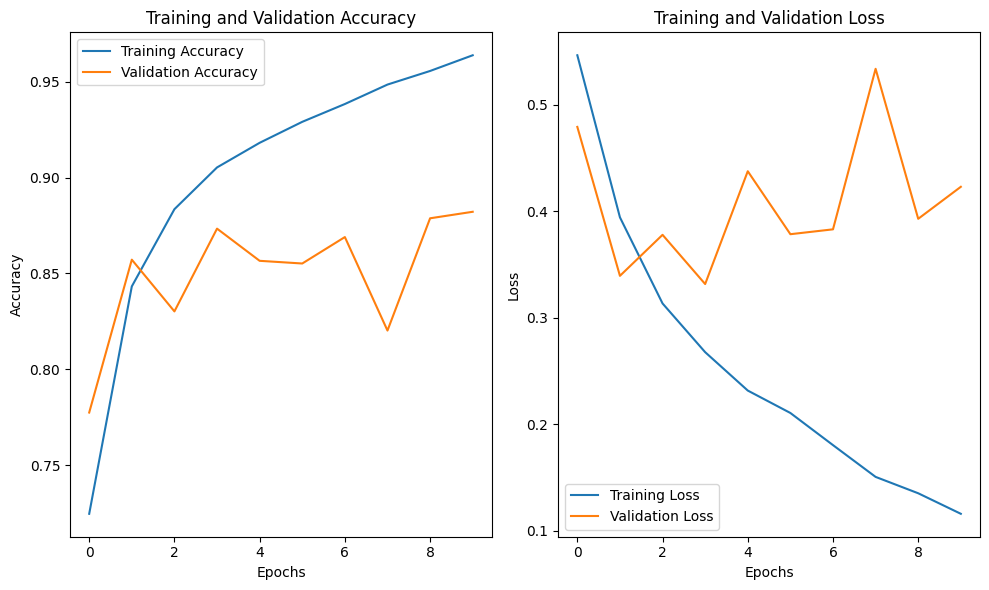

In [ ]:
import matplotlib.pyplot as plt

#Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

#Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_trace_v.history['accuracy'], label='Training Accuracy')
plt.plot(training_trace_v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot training and validation loss_v
plt.subplot(1, 2, 2)
plt.plot(training_trace_v.history['loss_v'], label='Training Loss')
plt.plot(training_trace_v.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 1

In [ ]:
from tensorflow.keras import layers

# Define max_tokens_v here
max_tokens_v = 20000
review_cap_v = 150

# Limit each review to 150 tokens
clip_vectorizer_v = layers.TextVectorization(
    max_tokens_v=max_tokens_v,
    output_mode_v="int",
    output_sequence_length_v=review_cap_v,  # Truncate or pad to 150 tokens
)
clip_vectorizer_v.adapt(train_text_stream_v)

# Prepare encoded datasets with 150-word limit
train_150_v = review_train_v.map(lambda x_v, y: (clip_vectorizer_v(x_v), y), num_parallel_calls_v=4)
val_150_v = review_valid_v.map(lambda x_v, y: (clip_vectorizer_v(x_v), y), num_parallel_calls_v=4)
test_150_v = review_test_v.map(lambda x_v, y: (clip_vectorizer_v(x_v), y), num_parallel_calls_v=4)

# Build the model with adjusted sequence length
cutoff_model_v = tf.keras.Sequential([
    layers.Embedding(input_dim_v=max_tokens_v, output_dim_v=128, input_length_v=review_cap_v),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
cutoff_model_v.compile(optimizer="rmsprop", loss_v="binary_crossentropy", metrics_v=["accuracy"])

# Save best-performing checkpoint
save_top_v = keras.callbacks_v.ModelCheckpoint("trimmed_bidir_lstm.keras", save_best_only=True)

# Train the model
history_trimmed_v = cutoff_model_v.fit(
    train_150_v,
    validation_data_v=val_150_v,
    epochs_v=10,
    callbacks_v=[save_top_v]
)

# Final evaluation
final_score_v = cutoff_model_v.evaluate(test_150_v)[1]
print(f"Test Accuracy (150 tokens): {final_score_v:.3f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6256 - loss: 0.6274 - val_accuracy: 0.8266 - val_loss: 0.3978
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8290 - loss: 0.4149 - val_accuracy: 0.8554 - val_loss: 0.3448
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8735 - loss: 0.3263 - val_accuracy: 0.7980 - val_loss: 0.5118
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8976 - loss: 0.2713 - val_accuracy: 0.8488 - val_loss: 0.3923
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9167 - loss: 0.2292 - val_accuracy: 0.8536 - val_loss: 0.4064
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9345 - loss: 0.1896 - val_accuracy: 0.8598 - val_loss: 0.3878
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9499 - loss: 0.1516 - val_accuracy: 0.8558 - val_loss: 0.4832
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9582 - loss: 0.1227 - val_accurac

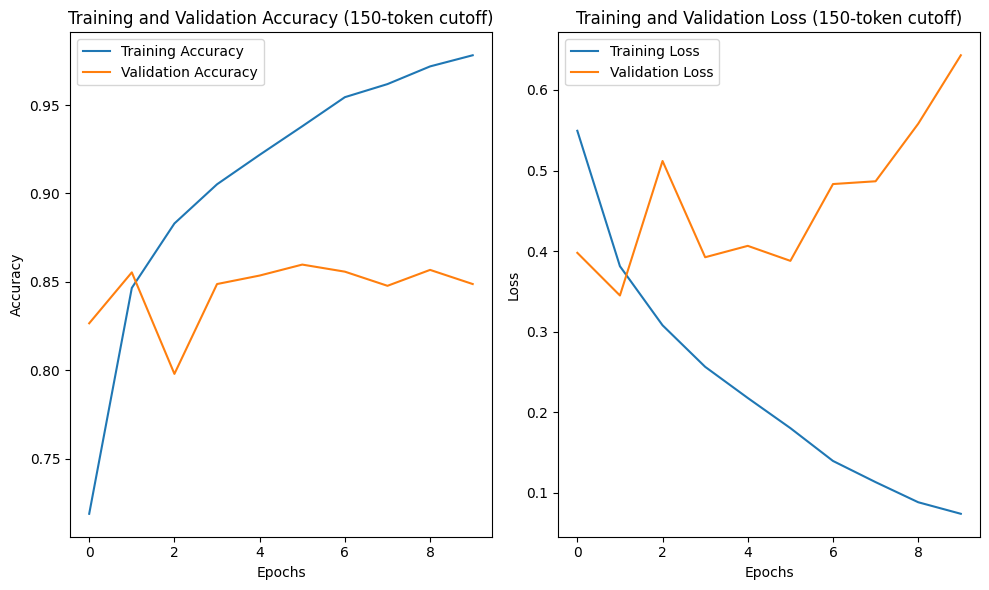

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss_v from history_trimmed_v
plt.figure(figsize=(10, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_trimmed_v.history['accuracy'], label='Training Accuracy')
plt.plot(history_trimmed_v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (150-token cutoff)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_trimmed_v.history['loss_v'], label='Training Loss')
plt.plot(history_trimmed_v.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (150-token cutoff)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 2

In [ ]:
# Restrict training data to only 100 samples
tiny_train_ds_v = train_encoded_v.take(100)

# Define a compact LSTM model
mini_lstm_model_v = tf.keras.Sequential([
    layers.Embedding(input_dim_v=max_tokens_v, output_dim_v=128, input_length_v=seq_limit_v),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
mini_lstm_model_v.compile(optimizer="rmsprop", loss_v="binary_crossentropy", metrics_v=["accuracy"])

# Train the model and store history
tiny_history_v = mini_lstm_model_v.fit(
    tiny_train_ds_v,
    validation_data_v=val_encoded_v,
    epochs_v=10
)

# Evaluate on test set
tiny_test_score_v = mini_lstm_model_v.evaluate(test_encoded_v)[1]
print(f"Test Accuracy with 100 samples: {tiny_test_score_v:.3f}")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4951 - loss: 0.6948 - val_accuracy: 0.5336 - val_loss: 0.6897
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.5774 - loss: 0.6723 - val_accuracy: 0.6830 - val_loss: 0.6111
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7324 - loss: 0.5607 - val_accuracy: 0.7390 - val_loss: 0.5393
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8217 - loss: 0.4328 - val_accuracy: 0.7946 - val_loss: 0.4597
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8722 - loss: 0.3382 - val_accuracy: 0.7814 - val_loss: 0.4951
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9034 - loss: 0.2628 - val_accuracy: 0.7936 - val_loss: 0.4752
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9095 - loss: 0.2550 - val_accuracy: 0.7782 - val_loss: 0.5028
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9555 - loss: 0.1524 - val_acc

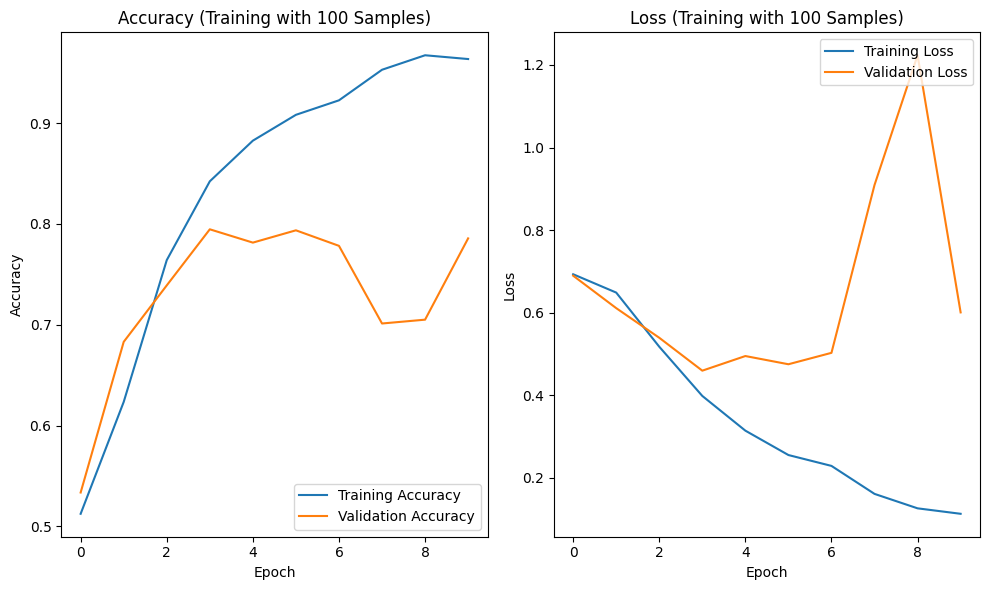

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation metrics_v for 100-sample experiment
plt.figure(figsize=(10, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(tiny_history_v.history['accuracy'], label='Training Accuracy')
plt.plot(tiny_history_v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (Training with 100 Samples)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(tiny_history_v.history['loss_v'], label='Training Loss')
plt.plot(tiny_history_v.history['val_loss'], label='Validation Loss')
plt.title('Loss (Training with 100 Samples)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

### Question 3

In [ ]:
# Limit validation dataset to 10,000 samples and train the model
val_encoded_10k_v = val_encoded_v.take(10000)

model_validate_10k_v = tf.keras.Sequential([
    layers.Embedding(vocab_limit_v, 128, input_length_v=seq_limit_v),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_validate_10k_v.compile(optimizer="rmsprop", loss_v="binary_crossentropy", metrics_v=["accuracy"])

history_validate_10k_v = model_validate_10k_v.fit(
    train_encoded_v,
    validation_data_v=val_encoded_10k_v,
    epochs_v=10
)

print(f"Test acc_v: {model_validate_10k_v.evaluate(test_encoded_v)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6114 - loss: 0.6336 - val_accuracy: 0.8056 - val_loss: 0.4488
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.8390 - loss: 0.4013 - val_accuracy: 0.8596 - val_loss: 0.3366
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8726 - loss: 0.3300 - val_accuracy: 0.8498 - val_loss: 0.3822
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8982 - loss: 0.2800 - val_accuracy: 0.8758 - val_loss: 0.3036
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9163 - loss: 0.2359 - val_accuracy: 0.8822 - val_loss: 0.3392
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9269 - loss: 0.2057 - val_accuracy: 0.8714 - val_loss: 0.3948
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9350 - loss: 0.1857 - val_accuracy: 0.8814 - val_loss: 0.3643
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9499 - loss: 0.1623 - 

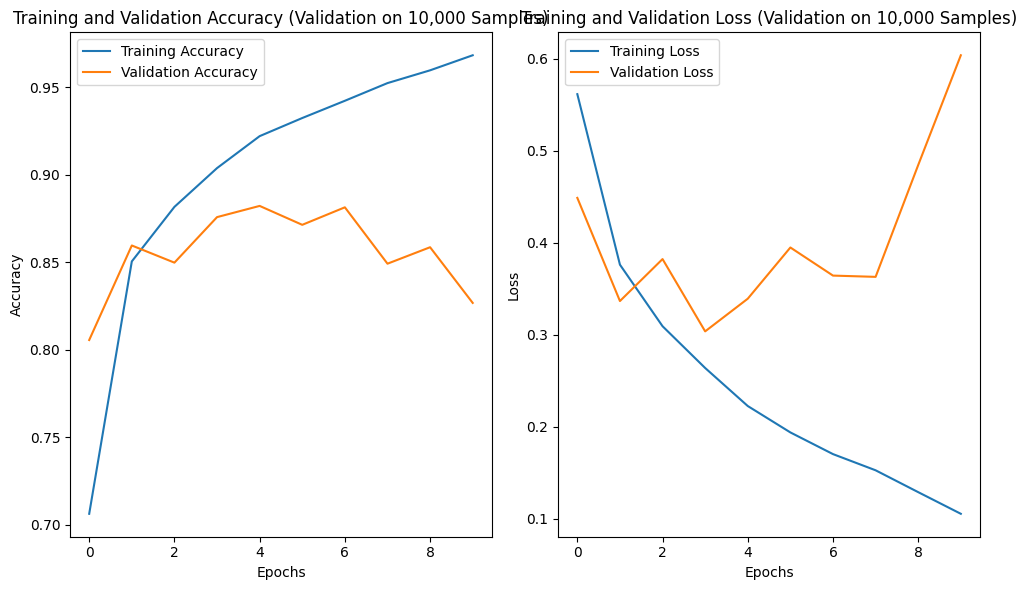

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_validate_10k_v.history['accuracy'], label='Training Accuracy')
plt.plot(history_validate_10k_v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Validation on 10,000 Samples)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss_v
plt.subplot(1, 2, 2)
plt.plot(history_validate_10k_v.history['loss_v'], label='Training Loss')
plt.plot(history_validate_10k_v.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Validation on 10,000 Samples)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 4

In [ ]:
# Adjust max_tokens_v to 10,000 and train the model
max_tokens_10k_v = 10000

text_vectorization_10k_v = layers.TextVectorization(
    max_tokens_v=max_tokens_10k_v,
    output_mode_v="int",
    output_sequence_length_v=seq_limit_v,  # fixed here
)
text_vectorization_10k_v.adapt(train_text_stream_v)

int_train_ds_10k_v = review_train_v.map(
    lambda x_v, y: (text_vectorization_10k_v(x_v), y),
    num_parallel_calls_v=4)

int_val_ds_10k_v = review_valid_v.map(
    lambda x_v, y: (text_vectorization_10k_v(x_v), y),
    num_parallel_calls_v=4)

int_test_ds_10k_v = review_test_v.map(
    lambda x_v, y: (text_vectorization_10k_v(x_v), y),
    num_parallel_calls_v=4)

model_top_10k_v = tf.keras.Sequential([
    layers.Embedding(max_tokens_10k_v, 128, input_length_v=seq_limit_v),  # also fixed
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_top_10k_v.compile(optimizer="rmsprop", loss_v="binary_crossentropy", metrics_v=["accuracy"])

history_top_10k_v = model_top_10k_v.fit(
    int_train_ds_10k_v,
    validation_data_v=int_val_ds_10k_v,
    epochs_v=10
)

print(f"Test acc_v: {model_top_10k_v.evaluate(int_test_ds_10k_v)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6104 - loss: 0.6334 - val_accuracy: 0.8394 - val_loss: 0.4057
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8300 - loss: 0.4185 - val_accuracy: 0.8524 - val_loss: 0.3533
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.8546 - loss: 0.3715 - val_accuracy: 0.8498 - val_loss: 0.3496
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.8813 - loss: 0.3123 - val_accuracy: 0.8838 - val_loss: 0.3059
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8973 - loss: 0.2846 - val_accuracy: 0.8726 - val_loss: 0.3237
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9138 - loss: 0.2444 - val_accuracy: 0.8750 - val_loss: 0.3320
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9216 - loss: 0.2296 - val_accuracy: 0.8704 - val_loss: 0.3296
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9310 - loss: 0.1977 - 

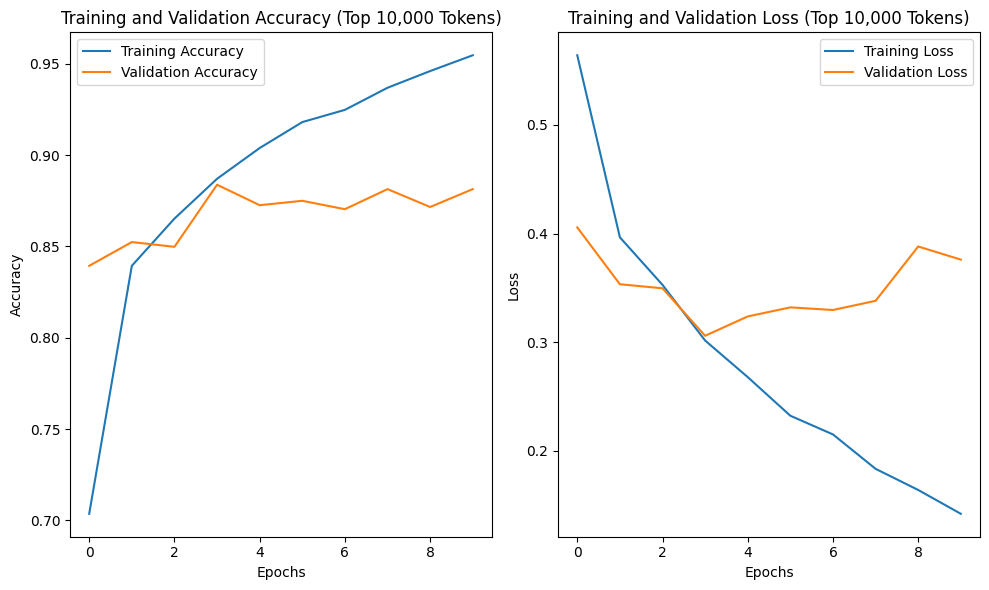

In [ ]:
# Plotting the training and validation accuracy for top 10,000 tokens model
plt.figure(figsize=(10, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_top_10k_v.history['accuracy'], label='Training Accuracy')
plt.plot(history_top_10k_v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Top 10,000 Tokens)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_top_10k_v.history['loss_v'], label='Training Loss')
plt.plot(history_top_10k_v.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Top 10,000 Tokens)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 5

In [ ]:
import urllib.request
import zipfile
import os

# Download GloVe zip if not already downloaded
glove_url_v = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_v = "glove.6B.zip"

if not os.path.exists(glove_zip_v):
    print("Downloading GloVe...")
    urllib.request.urlretrieve(glove_url_v, glove_zip_v)

# Extract glove.6B.100d.txt
if not os.path.exists("glove.6B.100d.txt"):
    print("Extracting glove.6B.100d.txt...")
    with zipfile.ZipFile(glove_zip_v, "r") as zip_ref:
        zip_ref.extract("glove.6B.100d.txt")

print("GloVe ready.")

📦 Extracting glove.6B.100d.txt...
GloVe ready.


Preparing pre trained model

In [ ]:
import os
import tarfile
import urllib.request
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Step 1: Download and extract dataset
imdb_url_v = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
archive_path_v = "acl_data.tar.gz"
urllib.request.urlretrieve(imdb_url_v, archive_path_v)

if archive_path_v.endswith("tar.gz"):
    with tarfile.open(archive_path_v, "r:gz") as extracted:
        extracted.extractall()

# Step 2: Remove unused data
junk_path_v = "aclImdb/train/unsup"
if os.path.exists(junk_path_v):
    import shutil
    shutil.rmtree(junk_path_v)

print("IMDB dataset ready for use.")

# Step 3: Load GloVe embeddings
glove_file_v = "glove.6B.100d.txt"
glove_vectors_v = {}

if os.path.exists(glove_file_v):
    with open(glove_file_v, encoding="utf-8") as glove_data:
        for line in glove_data:
            term, vector_str = line.split(maxsplit=1)
            vector_v = np.fromstring(vector_str, dtype="float32", sep=" ")
            glove_vectors_v[term] = vector_v
    print(f"Found {len(glove_vectors_v)} word vectors.")
else:
    print("GloVe file missing. Download and place glove.6B.100d.txt in the current directory.")

# Step 4: Setup vocab_v and embedding matrix
vocab_limit_v = 20000
sequence_limit_v = 200

fake_vectorizer_v = layers.TextVectorization(
    max_tokens_v=vocab_limit_v,
    output_sequence_length_v=sequence_limit_v
)

# Dummy vocab_v example (replace this with your actual vocab_v in real use)
sample_words_v = ["film", "plot", "funny", "boring", "nice", "awful"]
token_to_index_v = dict(zip(sample_words_v, range(len(sample_words_v))))

vector_size_v = 100
pretrained_matrix_v = np.zeros((vocab_limit_v, vector_size_v))

for token, idx in token_to_index_v.items():
    if idx < vocab_limit_v:
        vec_v = glove_vectors_v.get(token)
        if vec_v is not None:
            pretrained_matrix_v[idx] = vec_v

# Step 5: Define Embedding layers
trainable_embed_v = layers.Embedding(
    input_dim_v=vocab_limit_v,
    output_dim_v=vector_size_v,
    input_length_v=sequence_limit_v
)

frozen_embed_v = layers.Embedding(
    input_dim_v=vocab_limit_v,
    output_dim_v=vector_size_v,
    embeddings_initializer_v=initializers.Constant(pretrained_matrix_v),
    trainable_v=False,
    mask_zero_v=True
)

print("Embedding layers initialized and ready.")

IMDB dataset ready for use.
Found 400000 word vectors.
Embedding layers initialized and ready.


In [ ]:
# Vectorize the datasets using your token_encoder_v (TextVectorization layer)
int_train_ds_v = review_train_v.map(lambda x_v, y: (token_encoder_v(x_v), y), num_parallel_calls_v=4)
int_val_ds_v = review_valid_v.map(lambda x_v, y: (token_encoder_v(x_v), y), num_parallel_calls_v=4)
int_test_ds_v = review_test_v.map(lambda x_v, y: (token_encoder_v(x_v), y), num_parallel_calls_v=4)

In [ ]:
# Ensure these variables are defined before running this cell:
embedding_dim_v = 100
vocab_limit_v = 20000
seq_limit_v = 600

# Define a new trainable_v embedding layer
learned_embed_layer_v = layers.Embedding(
    input_dim_v=vocab_limit_v,
    output_dim_v=embedding_dim_v,
    input_length_v=seq_limit_v
)

# Define the model using the learned embedding layer
input_tensor_v = tf.keras.Input(shape=(None,), dtype="int64")
x_v = learned_embed_layer_v(input_tensor_v)
x_v = layers.Bidirectional(layers.LSTM(32))(x_v)
x_v = layers.Dropout(0.5)(x_v)
output_tensor_v = layers.Dense(1, activation="sigmoid")(x_v)

model_learned_embed_v = tf.keras.Model(input_tensor_v, output_tensor_v)
model_learned_embed_v.compile(optimizer="rmsprop", loss_v="binary_crossentropy", metrics_v=["accuracy"])

# Make sure int_train_ds_v, int_val_ds_v, int_test_ds_v are available from earlier vectorization
history_learned_embed_v = model_learned_embed_v.fit(
    int_train_ds_v,
    validation_data_v=int_val_ds_v,
    epochs_v=10
)

# Evaluate on the test dataset
print(f"Test acc_v (Trained Embedding): {model_learned_embed_v.evaluate(int_test_ds_v)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6186 - loss: 0.6254 - val_accuracy: 0.8296 - val_loss: 0.4216
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8286 - loss: 0.4276 - val_accuracy: 0.8758 - val_loss: 0.3138
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8716 - loss: 0.3373 - val_accuracy: 0.8660 - val_loss: 0.3574
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8975 - loss: 0.2896 - val_accuracy: 0.8700 - val_loss: 0.3326
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9149 - loss: 0.2483 - val_accuracy: 0.8432 - val_loss: 0.3424
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9263 - loss: 0.2198 - val_accuracy: 0.8722 - val_loss: 0.4240
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9360 - loss: 0.1921 - val_accuracy: 0.8742 - val_loss: 0.3244
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9493 - loss: 0.1579 - 

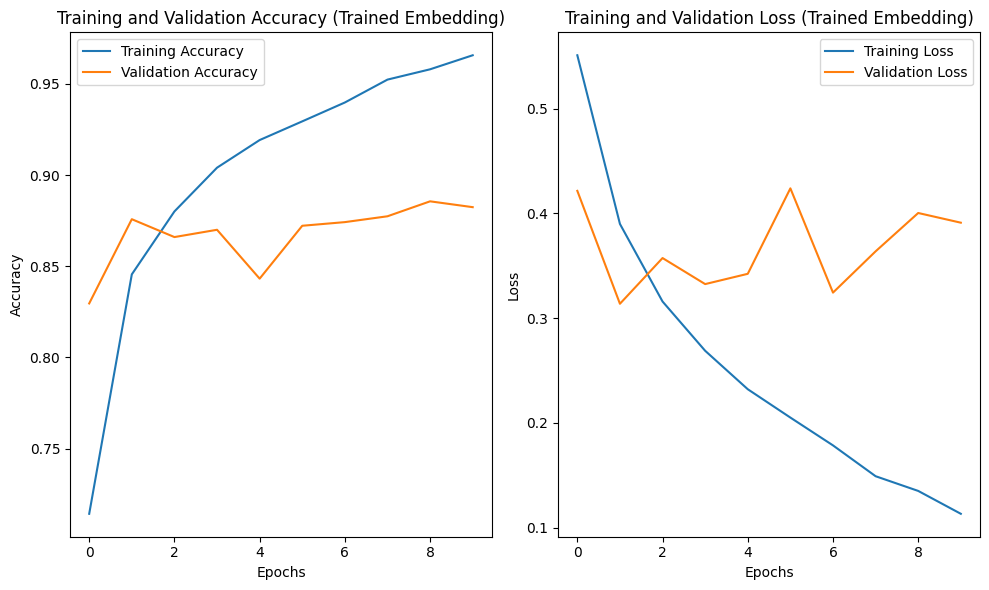

In [ ]:
# Plotting the training and validation accuracy/loss_v for the learned embedding model
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_learned_embed_v.history['accuracy'], label='Training Accuracy')
plt.plot(history_learned_embed_v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Trained Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_learned_embed_v.history['loss_v'], label='Training Loss')
plt.plot(history_learned_embed_v.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Trained Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import requests
import zipfile
import os
import numpy as np

# Step 1: Download GloVe zip file
glove_url_v = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_v = "glove.6B.zip"
glove_txt_v = "glove.6B.100d.txt"

if not os.path.exists(glove_txt_v):
    print("Downloading GloVe embeddings...")
    response_v = requests.get(glove_url_v)
    with open(glove_zip_v, "wb") as file:
        file.write(response_v.content)

    print("Extracting GloVe files...")
    with zipfile.ZipFile(glove_zip_v, 'r') as zip_ref:
        zip_ref.extractall(".")

    os.remove(glove_zip_v)  # Optional cleanup
    print("GloVe download and extraction complete.")
else:
    print("GloVe file already exists.")

# Step 2: Load glove.6B.100d.txt into a dictionary
embeddings_index_v = {}
try:
    print("Loading GloVe word vectors into dictionary...")
    with open(glove_txt_v, encoding="utf-8") as f:
        for line in f:
            word, coefs_v = line.split(maxsplit=1)
            coefs_v = np.fromstring(coefs_v, "f", sep=" ")
            embeddings_index_v[word] = coefs_v
    print(f"Found {len(embeddings_index_v)} word vectors.")
except FileNotFoundError:
    print(f"File not found: {glove_txt_v}")
except Exception as e:
    print(f"Error while loading GloVe: {e}")

GloVe file already exists.
Loading GloVe word vectors into dictionary...
Found 400000 word vectors.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

# Parameters
vocab_limit_v = 20000
embedding_dim_v = 100
seq_limit_v = 600
batch_size_v = 32

# Step 1: Load GloVe embeddings
glove_path_v = "glove.6B.100d.txt"
glove_vectors_v = {}
with open(glove_path_v, encoding="utf-8") as f:
    for line in f:
        word, coefs_v = line.split(maxsplit=1)
        coefs_v = np.fromstring(coefs_v, "f", sep=" ")
        glove_vectors_v[word] = coefs_v
print(f"Found {len(glove_vectors_v)} word vectors.")

# Step 2: Load dataset
review_train_v = keras.utils.text_dataset_from_directory("aclImdb/train", batch_size_v=batch_size_v)
review_valid_v = keras.utils.text_dataset_from_directory("aclImdb/val", batch_size_v=batch_size_v)
review_test_v = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size_v=batch_size_v)

# Step 3: Vectorization layer
train_text_stream_v = review_train_v.map(lambda text, label: text)
token_encoder_v = layers.TextVectorization(max_tokens_v=vocab_limit_v, output_sequence_length_v=seq_limit_v)
token_encoder_v.adapt(train_text_stream_v)

# Step 4: Create embedding matrix from GloVe
vocab_v = token_encoder_v.get_vocabulary()
word_index_v = dict(zip(vocab_v, range(len(vocab_v))))

embedding_matrix_v = np.zeros((vocab_limit_v, embedding_dim_v))
for word, i in word_index_v.items():
    if i < vocab_limit_v:
        vector_v = glove_vectors_v.get(word)
        if vector_v is not None:
            embedding_matrix_v[i] = vector_v

# Step 5: Define the frozen embedding layer
frozen_embed_v = layers.Embedding(
    input_dim_v=vocab_limit_v,
    output_dim_v=embedding_dim_v,
    embeddings_initializer_v=keras.initializers.Constant(embedding_matrix_v),
    trainable_v=False,
    mask_zero_v=True
)

# Step 6: Vectorize the datasets
def vectorize_data(text, label):
    return token_encoder_v(text), label

encoded_train_v = review_train_v.map(vectorize_data).cache().prefetch(tf.data.AUTOTUNE)
encoded_valid_v = review_valid_v.map(vectorize_data).cache().prefetch(tf.data.AUTOTUNE)
encoded_test_v = review_test_v.map(vectorize_data).cache().prefetch(tf.data.AUTOTUNE)

# Step 7: Build the model using GloVe embeddings
glove_input_v = tf.keras.Input(shape=(None,), dtype="int64")
x_v = frozen_embed_v(glove_input_v)
x_v = layers.Bidirectional(layers.LSTM(32))(x_v)
x_v = layers.Dropout(0.5)(x_v)
glove_output_v = layers.Dense(1, activation="sigmoid")(x_v)

glove_embed_model_v = tf.keras.Model(glove_input_v, glove_output_v)

# Step 8: Compile and train
glove_embed_model_v.compile(optimizer="rmsprop", loss_v="binary_crossentropy", metrics_v=["accuracy"])

glove_history_v = glove_embed_model_v.fit(
    encoded_train_v,
    validation_data_v=encoded_valid_v,
    epochs_v=10
)

# Step 9: Evaluate
glove_test_score_v = glove_embed_model_v.evaluate(encoded_test_v)[1]
print(f" Test Accuracy (GloVe Pretrained): {glove_test_score_v:.3f}")

Found 400000 word vectors.
Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.6298 - loss: 0.6273 - val_accuracy: 0.7944 - val_loss: 0.4517
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7919 - loss: 0.4578 - val_accuracy: 0.8270 - val_loss: 0.3845
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.8212 - loss: 0.3999 - val_accuracy: 0.8252 - val_loss: 0.3771
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8431 - loss: 0.3652 - val_accuracy: 0.8732 - val_loss: 0.3074
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.8561 - loss: 0.3377 - val_accuracy: 0.8862 - val_loss: 0.2798
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.8669 - loss: 0.3129 - val_accuracy: 0.8872 - val_loss: 0.2772
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.

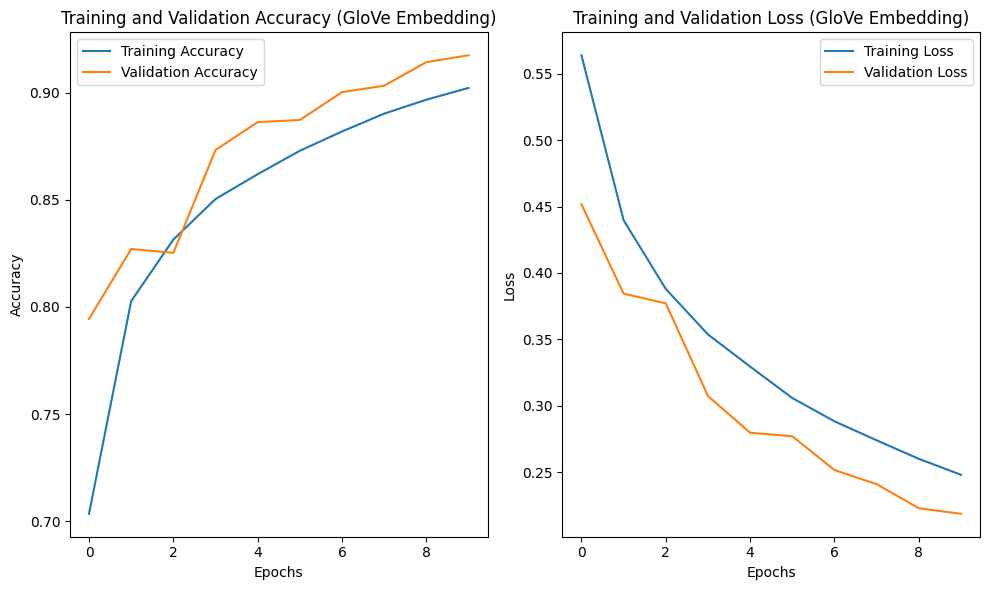

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss_v for GloVe-based model
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(glove_history_v.history['accuracy'], label='Training Accuracy')
plt.plot(glove_history_v.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (GloVe Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(glove_history_v.history['loss_v'], label='Training Loss')
plt.plot(glove_history_v.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GloVe Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


🔁 Training with 100 samples...
✅ Training Size: 100, Test Accuracy: 0.634

🔁 Training with 500 samples...
✅ Training Size: 500, Test Accuracy: 0.772

🔁 Training with 1000 samples...
✅ Training Size: 1000, Test Accuracy: 0.778

🔁 Training with 5000 samples...
✅ Training Size: 5000, Test Accuracy: 0.786

🔁 Training with 625 samples...
✅ Training Size: 625, Test Accuracy: 0.790

📊 Final Test Accuracies:
Training Size: 100, Test Accuracy: 0.634
Training Size: 500, Test Accuracy: 0.772
Training Size: 1000, Test Accuracy: 0.778
Training Size: 5000, Test Accuracy: 0.786
Training Size: 625, Test Accuracy: 0.790


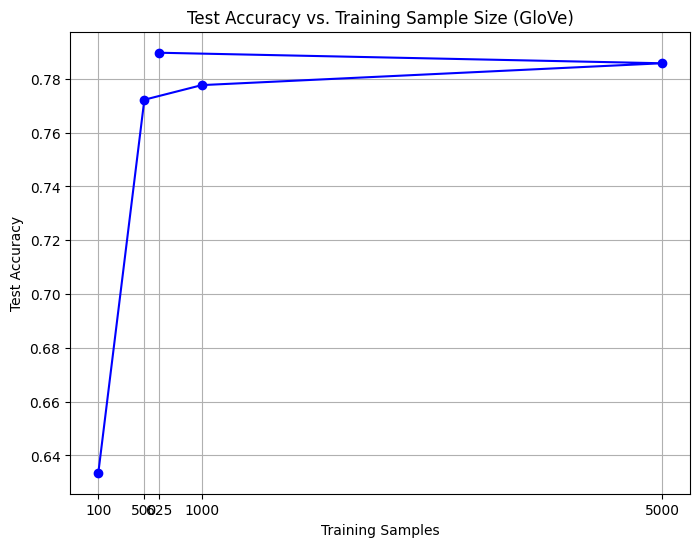

In [ ]:
import matplotlib.pyplot as plt

# Define different training sample sizes
sample_sizes_v = [100, 500, 1000, 5000, len(list(int_train_ds_v))]

# Store test accuracies
test_acc_vs_size_v = []

for size in sample_sizes_v:
    # Limit the training dataset
    partial_train_ds_v = int_train_ds_v.take(size)

    # Define model with frozen GloVe embedding
    sample_input_v = tf.keras.Input(shape=(None,), dtype="int64")
    x_v = frozen_embed_v(sample_input_v)
    x_v = layers.Bidirectional(layers.LSTM(32))(x_v)
    x_v = layers.Dropout(0.5)(x_v)
    sample_output_v = layers.Dense(1, activation="sigmoid")(x_v)

    sample_model_v = tf.keras.Model(sample_input_v, sample_output_v)
    sample_model_v.compile(optimizer="rmsprop", loss_v="binary_crossentropy", metrics_v=["accuracy"])

    # Train on subset
    print(f"\n Training with {size} samples...")
    sample_model_v.fit(partial_train_ds_v, validation_data_v=int_val_ds_v, epochs_v=10, verbose=0)

    # Evaluate
    acc_v = sample_model_v.evaluate(int_test_ds_v, verbose=0)[1]
    test_acc_vs_size_v.append(acc_v)
    print(f"Training Size: {size}, Test Accuracy: {acc_v:.3f}")

# Print final results
print("\n Final Test Accuracies:")
for s, a in zip(sample_sizes_v, test_acc_vs_size_v):
    print(f"Training Size: {s}, Test Accuracy: {a:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes_v, test_acc_vs_size_v, marker='o', linestyle='-', color='blue')
plt.title("Test Accuracy vs. Training Sample Size (GloVe)")
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(sample_sizes_v)
plt.show()